In [1]:
using MAT
using Plots
using Random
using StatsBase
using JLD

using Revise
using PointProcessSequences

include("util.jl")

┌ Info: Precompiling PointProcessSequences [d68ed3fc-988c-453b-86e7-a6411c80bd32]
└ @ Base loading.jl:1273


init_distr_model (generic function with 1 method)

### Load data

In [2]:
filepath = "/home/asd/data/ppm/"
md = matread(filepath * "buzaki/Achilles_10252013_sessInfo.mat")
println("Loaded.")

Loaded.


In [3]:
# Load times and cluster assignments
spike_times = md["sessInfo"]["Spikes"]["SpikeTimes"]
spike_clusters = md["sessInfo"]["Spikes"]["SpikeIDs"]

vid_times = md["sessInfo"]["Position"]["TimeStamps"]
vid_positions = md["sessInfo"]["Position"]["TwoDLocation"]

# Label each spike as an integer
cluster_labels = unique(spike_clusters)
spike_neurons = [
    findfirst(n->n==s, cluster_labels) 
    for s in spike_clusters
]


# Filter out spikes that don't occur during maze epoch
start_time, end_time = md["sessInfo"]["Epochs"]["MazeEpoch"]

# Add a little buffer REMOVE
start_time += 100

# And spikes that spikes with a low neuron label 
# (occur too often :/) REMOVE
min_neuron = 40

# And limit the total dataset size 
# (max should be 220,000 or so) REMOVE
max_spikes = Inf  #50_000

spikes = Spike[]
for (n, t) in zip(spike_neurons, spike_times)
    if t >= start_time && t <= end_time && n > min_neuron
        push!(spikes, Spike(n - min_neuron, t - start_time))
    end
    
    if length(spikes) >= max_spikes
        break
    end
end


vtimes = []
vposes = []
for i = 1:length(vid_times)
    if vid_times[i] >= start_time && vid_times[i] <= end_time
        push!(vtimes, vid_times[i] - start_time)
        push!(vposes, vid_positions[i, :])
    end
end

println(length(spikes))
println("Processed.")

215003
Processed.


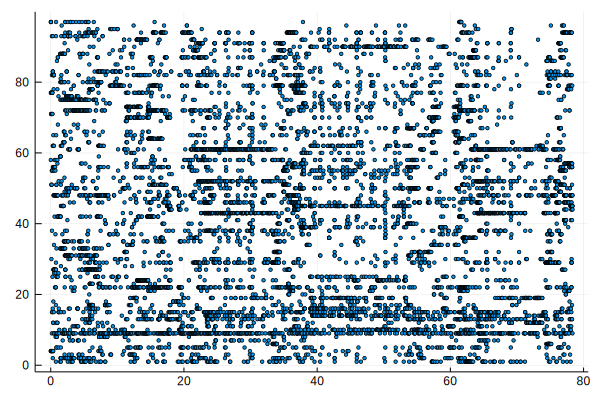

In [4]:
# Plot data
first = 1
last = 10_000

scatter(
    [s.timestamp for s in spikes[first:last]], 
    [s.neuron for s in spikes[first:last]], 
    ms=2,
    legend=false
)

### Fit data

In [5]:
include("util.jl")

max_time = spikes[end].timestamp + 10
num_neurons = length(cluster_labels) - min_neuron

@show num_spikes = length(spikes)
@show spikes_per_sec = num_spikes / max_time

nthreads = 32

num_motifs = 3

bkgd_rate = 0.1 * spikes_per_sec

amplitude = 30
event_rate = 0.1
seq_width = 10.0^2
max_sequence_length = 30.0

seq_type_proportions = SymmetricDirichlet(1.0, num_motifs)
bkgd_proportions = SymmetricDirichlet(1.0, num_neurons)
neuron_response_proportions = SymmetricDirichlet(0.1, num_neurons)

bkgd_amplitude = specify_gamma(   
    bkgd_rate,     # mean of gamma; α / β
    bkgd_rate * 1e-5,     # variance of gamma; α / β²
)

seq_event_amplitude = specify_gamma(amplitude, amplitude^2 / 2^2)
neuron_response_profile = NormalInvChisq(
    1.0,   # κ, pseudo-observations of prior mean
    0.0,   # m, prior mean for offset parameter
    2.0,   # ν, pseudo-observations of prior variance
    seq_width    # s2, prior variance
)

model = DistributedPPSeq(
    # constants
    nthreads,  # threads
    max_time,
    max_sequence_length,

    # warp parameters
    1,
    1.0,
    1.0,

    # priors
    event_rate,
    seq_type_proportions,
    seq_event_amplitude,
    neuron_response_proportions,
    neuron_response_profile,
    bkgd_amplitude,
    bkgd_proportions
)

print("Initialized model.")

num_spikes = length(spikes) = 215003
spikes_per_sec = num_spikes / max_time = 108.72487501175411
(warp_values, warp_log_proportions) = ([1.0], [0.0])
Initialized model.

TEMP:  4.0
10-20-30-40-50-Done
TEMP:  1.0
10-20-30-40-50-Done


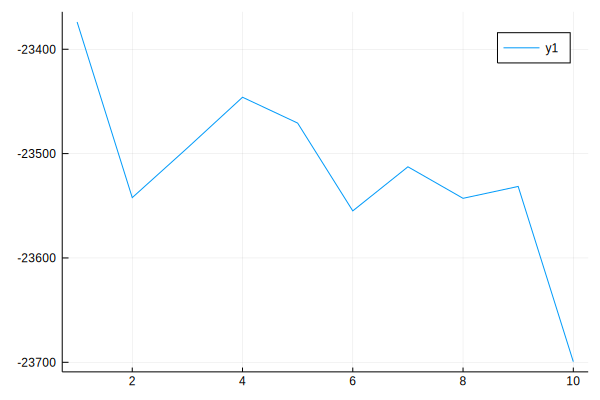

  0.335084 seconds (373.48 k allocations: 18.075 MiB)
length(unique(r[1])) = 2


2

In [8]:
include("util.jl")

init_assgn = fill(-1, length(spikes[1:1000]))

num_anneals = 2
samples_per_anneal = 50
max_temp = 2.0^2

save_every = 10

@time r = annealed_gibbs!(
#@time r = gibbs_sample!(
    model, spikes[1:1000], init_assgn,
    num_anneals, samples_per_anneal, max_temp,
    #samples_per_anneal,
    0, 0.0,
    save_every;
    verbose=true
)


# plot log likelihood history
display(plot(r[3]))
@show length(unique(r[1]))

In [161]:
@save "/home/asd/data/ppm/maze_run1.jld" model r 

### Plot results

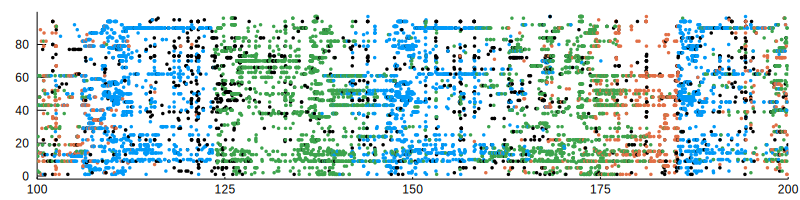

In [154]:
include("util.jl")

first = 10_000
last = 25_000

assgn = r[1]
rspikes = [
    (k == -1) ? -1 : model.primary_model.sequence_events[k].sampled_type 
    for k in assgn
]

p = plot_raster(spikes[first:last], rspikes[first:last])  #, model=model.primary_model)
plot!(p, xlim=(100, 200))

In [157]:
# Aggregate models
pm = model.primary_model

nspikes = [spk.neuron for spk in spikes]
tspikes = [spk.timestamp for spk in spikes]
rspikes = [
    (k == -1) ?
    -1 :
    pm.sequence_events[k].sampled_type
    for k in assgn
]

event_ids = [
    i
    for i in pm.sequence_events.indices
]
event_times = [
    e.sampled_timestamp
    for e in pm.sequence_events
]
event_types = [
    e.sampled_type
    for e in pm.sequence_events
]

spike_labels = rspikes[first:last]
spike_times = tspikes[first:last]
spike_neurons = nspikes[first:last]

# Sort neurons by cluster
weights = zeros(5, num_neurons)
for (l, n) in zip(rspikes, nspikes)
    if l != -1
        weights[l, n] += 1
    end
end


preferences = reshape([ind[1] for ind in argmax(weights, dims=1)], :)
perm = sort(
    collect(1:num_neurons), 
    by=n->(preferences[n], pm.globals.neuron_response_offsets[n, preferences[n]])
)
spike_neurons = [findfirst(l->l==n, perm) for n in spike_neurons]

viz_spikes = [Spike(n, t) for (n, t) in zip(spike_neurons, spike_times)]


p1 = plot_raster(viz_spikes, rspikes[first:last])
plot!(p1, xlim=(100, 200))
vt = vtimes[1:10_000]
vp = vposes[1:10_000]
vp = hcat(vp...)'

p2 = plot(vt, vp, xlim=(100, 200), size=(800, 200), legend=false)

fig = plot(p1, p2, layout=(2, 1))
savefig(fig, "/home/asd/pics/seq-mix/maze-rerun.png")
display(fig)

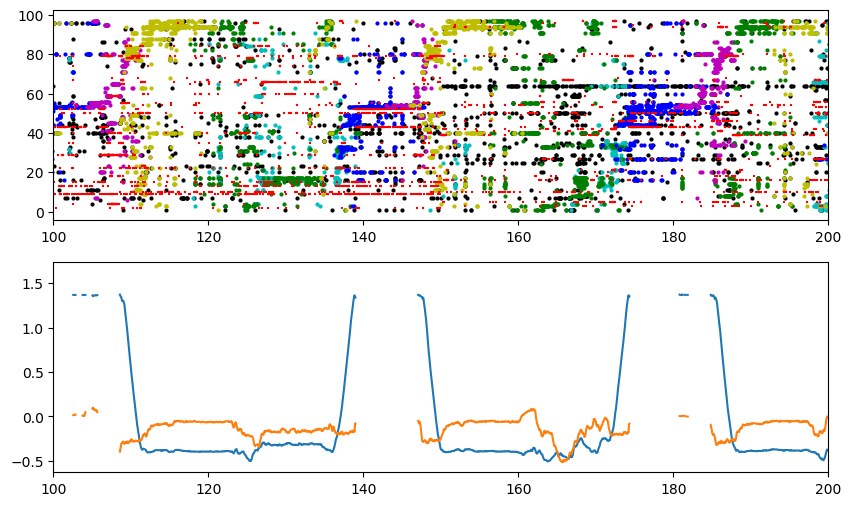

In [160]:
m1 = model.primary_model
first = 1
last = 50_000

spike_labels = rspikes[first:last]
spike_times = tspikes[first:last]
spike_neurons = nspikes[first:last]

# Sort neurons by cluster
weights = zeros(5, num_neurons)
for (l, n) in zip(rspikes, nspikes)
    if l != 0
        weights[l, n] += 1
    end
end

#weights = m1.neuron_distr .* m1.event_type_distr

preferences = reshape([ind[1] for ind in argmax(weights, dims=1)], :)
perm = sort(collect(1:num_neurons), by=n->(preferences[n], m1.offsets[preferences[n], n]))
spike_neurons = [findfirst(l->l==n, perm) for n in spike_neurons]


# Plot results
colors = ["k", "c", "g", "b", "m", "y"]
plt.figure(figsize=(10, 6))
xstart = 100
xend = xstart + 100

plt.subplot(2, 1, 1)
for r = 0:5
    active = (spike_labels .== r)
    plt.scatter(
        spike_times[active],
        spike_neurons[active],
        color=colors[r+1],
        s=4
    )
end

### Cross validate

In [159]:
Threads.nthreads()

1

### Next steps

* Develop heuristics to estimate `num_motifs` and `type_conc_prior`, among other things.

In [159]:
# Random.seed!(474)

# @show max_time = spikes[end].time
# @show num_neurons = length(cluster_labels) - min_neuron

# Withhold some neurons
#test_pc = 0.10
#test_neuron_pc = 0.30
#test_time_pc = test_pc / test_neuron_pc

# Step 1: partition time
#interval_size = 50
#splits = collect(range(0, max_time, step=interval_size))
#push!(splits, max_time)

#intervals = [(splits[k], splits[k+1]) for k = 1:length(splits)-1]
#num_intervals = length(intervals)

# Step 2: sample test intervals
#test_intervals = sample(
#     intervals,
#     floor(Int, test_time_pc * num_intervals), 
#     replace=false
# )

# # Step 3: sample neurons within test interval
# test_neurons = []
# for _ in test_intervals
#     push!(test_neurons, sample(
#             1:num_neurons, 
#             floor(Int, test_neuron_pc*num_neurons), 
#             replace=false
#     ))
# end

# # Step 4: withhold data
# train = Spike[]
# test = [[] for _ in intervals]
# for spk in spikes
#     is_test = false
#     for k = 1:length(test_intervals)
#         t1, t2 = test_intervals[k]
#         neurons = test_neurons[k]
        
#         if spk.time > t1 && spk.time < t2 && spk.neuron in neurons
#             push!(test[k], spk)
#             is_test = true
#         end
#     end
    
#     if !is_test
#         push!(train, spk)
#     end
# end

# @show length(train)
# @show sum(length.(test))
# println("Data partitioned!")






# # also plot test spikes
# all_test = vcat(test...)
# tt = [spk.timestamp for spk in all_test]
# tn = [spk.neuron for spk in all_test]
# plt.scatter(
#     tt,
#     tn,
#     color="r",
#     s=2,
#     marker="+"
# )


# plt.xlim(xstart, xend)








# # Step 6: estimate predicted number of spikes for each withheld neuron during each withheld time window
# pred_rates = []
# for (t1, t2) in test_intervals
#     local_events = events[[t1 < e._time < t2 for e in events]]
#     firing_rate = zeros(num_neurons)
    
#     # Add background contribution
#     scale = (length(all_test) + length(train)) / length(train)
#     firing_rate += m1.bkgd_neuron_distr * m1.bkgd_rate * scale * (t2 - t1) / max_time
#     for e in local_events
#         firing_rate += m1.neuron_distr[e._type, :] * e._rate * scale
#     end
    
#     push!(pred_rates, firing_rate)
# end

# #@show length(pred_rates)
# #@show length(test_neurons)

# # Step 7: compare against actual withheld neurons
# count = 0
# error = 0
# for (k, nlist) in enumerate(test_neurons)
#     for n in nlist
#         est = pred_rates[k][n]
#         truth = sum([spk.neuron == n for spk in test[k]])
#         error += (est - truth)^2
        
#         count += truth^2
#     end
# end

# @show sqrt(error / count)

max_time = (spikes[end]).time = 1967.4959500000004
num_neurons = length(cluster_labels) - min_neuron = 97
length(train) = 193587
sum(length.(test)) = 21416
Data partitioned!
